## Mini Project 1 notebook

### Importations 

In [1]:
#!/usr/bin/env python

import torch

import dlc_practical_prologue as prologue

from torch.autograd import Variable
from torch import nn, optim
from torch.nn import functional as F


print(torch.__version__)

train_input, train_target, train_classes, test_input, test_target, test_classes = \
    prologue.generate_pair_sets(nb=1000)


1.0.1.post2


In [2]:
import matplotlib.pyplot as plt

### Goal

Let's have some insight about the data and what we are supposed to do.

The goal of the project is to compare different architectures, and assess the performance improvement
that can be achieved through weight sharing, or using auxiliary losses. 

We have too implement a deep network such that, given as input a series of 2 ×14×14
tensor, corresponding to pairs of 14 × 14 grayscale images, it predicts for each pair if the first digit is
lesser or equal to the second.

### Insight on the data

First we want to visualize a pair of 14 x 14 grayscale image. 

We load the first pair and diplay it using matplotlib

In [3]:
train_input.shape

torch.Size([1000, 2, 14, 14])

In [4]:
pair = train_input[0]

In [5]:
pair.shape

torch.Size([2, 14, 14])

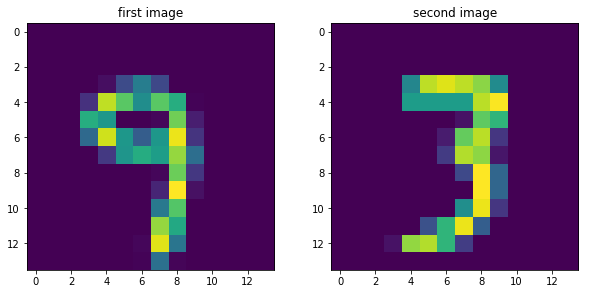

In [6]:
plt.figure(figsize=(10,10))
           
plt.subplot(2,2,1)
plt.imshow(pair[0])
plt.title('first image')


plt.subplot(2,2,2)
plt.imshow(pair[1])
plt.title('second image')


plt.show()

In [7]:
train_target[0]

tensor(0)

Let's have a look at their corresponding labels.

In [8]:
train_classes[0]

tensor([9, 3])

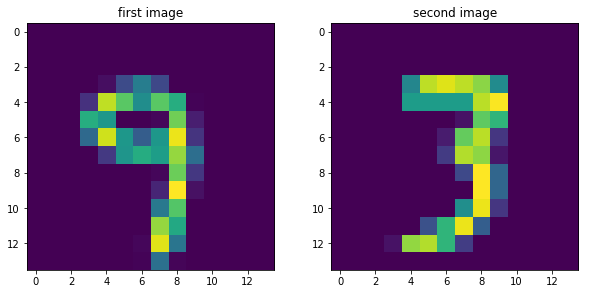

target =  tensor(0)
train_classes =  tensor([9, 3])


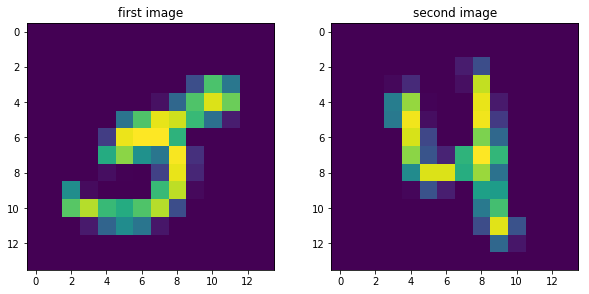

target =  tensor(0)
train_classes =  tensor([5, 4])


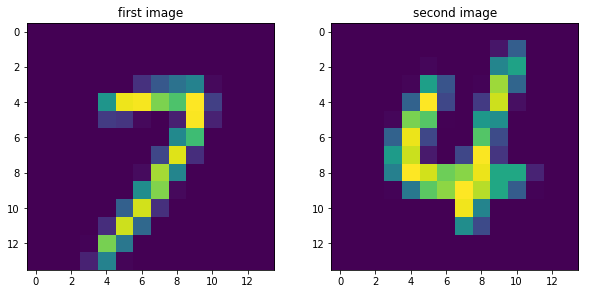

target =  tensor(0)
train_classes =  tensor([7, 4])


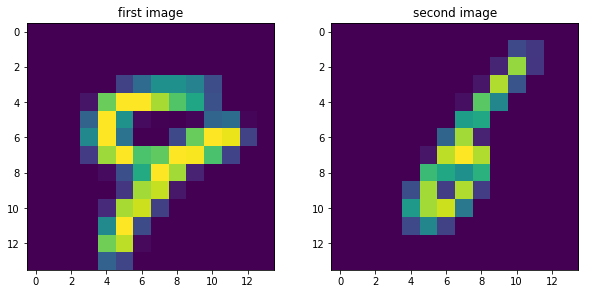

target =  tensor(0)
train_classes =  tensor([9, 6])


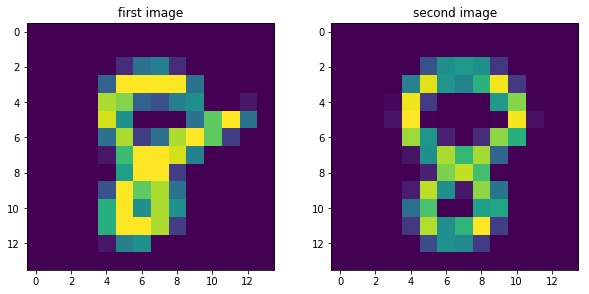

target =  tensor(1)
train_classes =  tensor([8, 8])


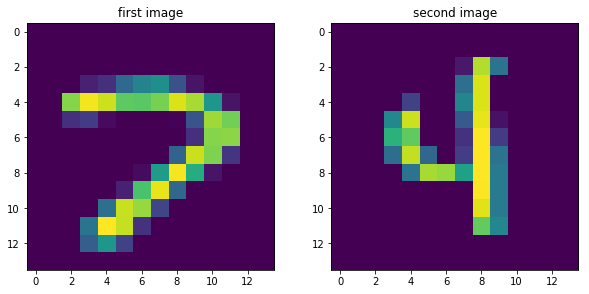

target =  tensor(0)
train_classes =  tensor([7, 4])


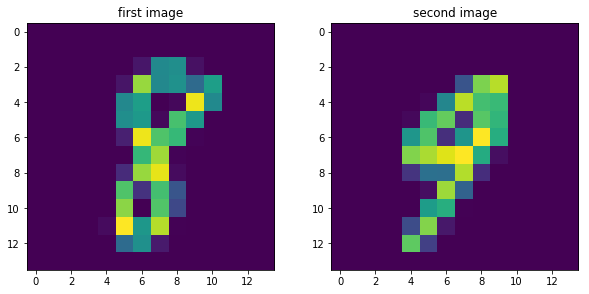

target =  tensor(1)
train_classes =  tensor([8, 9])


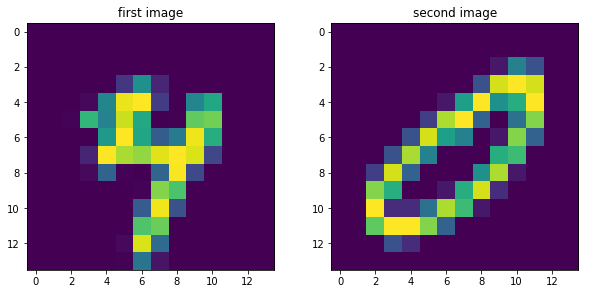

target =  tensor(0)
train_classes =  tensor([4, 0])


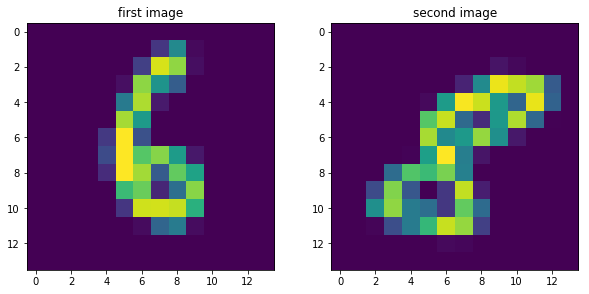

target =  tensor(1)
train_classes =  tensor([6, 8])


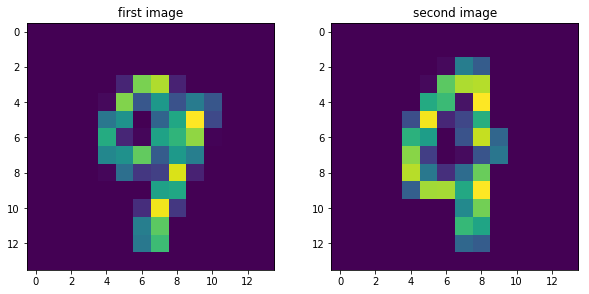

target =  tensor(1)
train_classes =  tensor([9, 9])


In [9]:
for t in range(10):
    pair = train_input[t]
    plt.figure(figsize=(10,10))
           
    plt.subplot(2,2,1)
    plt.imshow(pair[0])
    plt.title('first image')


    plt.subplot(2,2,2)
    plt.imshow(pair[1])
    plt.title('second image')


    plt.show()
    
    print("target = ", train_target[t])
    print("train_classes = ", train_classes[t])

Note that the corresponding classes from our first pair are 4 and 9 which is consistent with the images we had. However we can see that the quality of the image is poor and hard to read from human perspective.

By printing out a few of the training set with target and classes we can see straight away that some pairs are wrongly labelled!

# Architecture 1.0 : vanilla CNN to recognize digits 

In this section, we will focus on building a vanilla CNN in order to recognize the digits from each image from each pairs. Once done, we will then compare "by hand" the comparision between the predicted pair. This is the most basic setup and will try to improve latter.

## 1.1 Creating Model

In [10]:
class Net(nn.Module):
    def __init__(self,nb_hidden = 200):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [11]:
class Net2(nn.Module):
    def __init__(self,nb_hidden = 200):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(64, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
    

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 64)))
        x = self.fc2(x)
        return x

We need to prepare the data to feed the model.

In [12]:
def prep_input_vanilla(train_input):
    new_train_input = train_input.view(-1,1,14,14)
    return new_train_input

In [13]:
def prep_target_vanilla(train_classes):
    
    train_classes = train_classes.flatten()
    
    stack = torch.tensor([0.0]*10)
    
    for i in train_classes:
        current = torch.tensor([0.0]*10)
        current[i.item()] = 1
        stack = torch.cat([stack.view(-1,10),current.view(-1,10)])
        
    return stack[1:]
        

### Begin of Sanity check:

In [14]:
t = prep_input_vanilla(train_input)
t.shape

torch.Size([2000, 1, 14, 14])

In [15]:
t[0].shape

torch.Size([1, 14, 14])

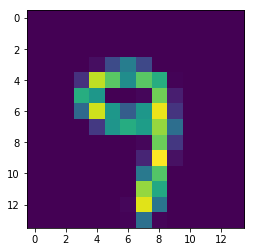

In [16]:
plt.imshow(t[0].view(14,14))

In [17]:
l = prep_target_vanilla(train_classes)
l.shape

torch.Size([2000, 10])

In [18]:
l[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

### End of sanity check

## 1.2 Training the model

In [19]:
mini_batch_size = 100 
nb_epochs = 25
eta = 0.001 #learning rate
#criterion = nn.MSELoss() # loss
criterion = torch.nn.CrossEntropyLoss()

In [20]:
def train_model(model, train_input, train_target, mini_batch_size, criterion, nb_epochs, eta):
    print("train_input = ", train_input.type)
    print("train_target = ", train_target.type)
    optimizer = torch.optim.SGD(model.parameters(), lr = eta, momentum = 0.95) #Stochastic gradient descent
    
    for e in range(0, nb_epochs):
        # We do this with mini-batches
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            print("output.shape = ", output.type)
            print(output[0])
            target = train_target.narrow(0, b, mini_batch_size)
            print("target.shape = ", target.shape)
            print(target[0])
            #loss = criterion(output,target)
            print("dgfss = ", target.max(1)[1])
            print("gfdgdgdg = ", target.max(1)[1].shape)
            loss = criterion(output,target.max(1)[1])
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(e, loss.data.item())
    

In [21]:
def prepare_vanilla(train_input,train_classes):
    
    return prep_input_vanilla(train_input), prep_target_vanilla(train_classes)


In [22]:
model = Net()

#train_input_1 = prep_input_vanilla(train_input)
#train_target_1 = prep_target_vanilla(train_classes)
train_input_1, train_target_1 = prepare_vanilla(train_input, train_classes)
train_input_1, train_target_1 = Variable(train_input_1), Variable(train_target_1)
print(train_target_1)

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])


In [23]:
train_classes.flatten()[:100]

tensor([9, 3, 5, 4, 7, 4, 9, 6, 8, 8, 7, 4, 8, 9, 4, 0, 6, 8, 9, 9, 3, 1, 3, 2,
        5, 0, 2, 1, 6, 5, 5, 4, 7, 4, 1, 8, 7, 3, 3, 5, 1, 6, 0, 1, 4, 4, 0, 0,
        7, 0, 6, 7, 8, 9, 2, 1, 0, 7, 9, 2, 6, 8, 7, 7, 2, 8, 8, 5, 7, 1, 9, 3,
        1, 2, 4, 8, 6, 5, 1, 6, 5, 6, 8, 8, 5, 0, 2, 7, 2, 5, 8, 7, 7, 7, 2, 7,
        8, 8, 7, 7])

In [24]:
train_model(model,train_input_1,train_target_1,mini_batch_size,criterion,nb_epochs,eta)

train_input =  <built-in method type of Tensor object at 0x7f8058fdcca8>
train_target =  <built-in method type of Tensor object at 0x7f8058f63ea0>
output.shape =  <built-in method type of Tensor object at 0x7f8058fda438>
tensor([ 1.0008,  6.3652,  0.2859, -5.0930,  8.3421,  8.6901,  1.0041, -7.3581,
        -3.2682, -2.9248], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
dgfss =  tensor([9, 3, 5, 4, 7, 4, 9, 6, 8, 8, 7, 4, 8, 9, 4, 0, 6, 8, 9, 9, 3, 1, 3, 2,
        5, 0, 2, 1, 6, 5, 5, 4, 7, 4, 1, 8, 7, 3, 3, 5, 1, 6, 0, 1, 4, 4, 0, 0,
        7, 0, 6, 7, 8, 9, 2, 1, 0, 7, 9, 2, 6, 8, 7, 7, 2, 8, 8, 5, 7, 1, 9, 3,
        1, 2, 4, 8, 6, 5, 1, 6, 5, 6, 8, 8, 5, 0, 2, 7, 2, 5, 8, 7, 7, 7, 2, 7,
        8, 8, 7, 7])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80590a15a0>
tensor([ 20.7352, -13.7013,  20.8405,  12.2909, -76.4366,  11.0880,  11.9859,
         20.6545,  23.0396,

output.shape =  <built-in method type of Tensor object at 0x7f8058fdcd38>
tensor([ 0.1267,  0.1624,  0.0681, -0.1902, -0.1157, -0.1256, -0.0092, -0.0073,
        -0.1520,  0.0716], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
dgfss =  tensor([8, 8, 3, 7, 1, 4, 7, 9, 3, 1, 5, 4, 6, 1, 6, 2, 1, 8, 7, 6, 1, 2, 1, 7,
        3, 0, 6, 0, 1, 1, 3, 9, 8, 3, 4, 3, 2, 9, 7, 9, 2, 5, 8, 7, 2, 1, 4, 5,
        7, 3, 3, 2, 0, 5, 2, 8, 4, 1, 6, 1, 1, 5, 6, 1, 6, 9, 2, 9, 9, 7, 3, 7,
        6, 1, 1, 0, 1, 5, 5, 5, 2, 3, 6, 1, 6, 3, 8, 0, 5, 8, 1, 1, 6, 7, 6, 0,
        8, 5, 1, 1])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80590aa708>
tensor([ 0.1093,  0.1089,  0.0075, -0.1273, -0.0307, -0.1288, -0.0295,  0.0096,
        -0.0540,  0.0460], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
dgfss =  tensor([8, 3, 4, 8, 9, 

output.shape =  <built-in method type of Tensor object at 0x7f8058fdcd38>
tensor([ 0.4199,  0.6455,  0.5810, -1.2662, -0.7261, -0.6872, -0.0061,  0.1788,
        -0.2469,  0.4079], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
dgfss =  tensor([3, 8, 1, 4, 1, 5, 1, 5, 0, 7, 3, 1, 6, 9, 4, 8, 2, 2, 2, 6, 1, 4, 1, 1,
        6, 8, 9, 0, 5, 1, 0, 5, 1, 7, 7, 1, 2, 7, 0, 1, 0, 8, 8, 9, 9, 0, 1, 3,
        7, 8, 2, 2, 3, 5, 8, 0, 8, 9, 4, 3, 3, 2, 9, 1, 4, 9, 9, 9, 1, 4, 6, 5,
        0, 3, 9, 1, 2, 6, 1, 3, 4, 1, 4, 1, 5, 7, 5, 1, 6, 9, 4, 2, 9, 7, 3, 0,
        2, 9, 2, 0])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80595aefc0>
tensor([ 0.4197,  0.6857,  0.5737, -1.0482, -0.6971, -0.5633,  0.0761,  0.3214,
        -0.3734,  0.4050], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
dgfss =  tensor([7, 5, 9, 0, 9, 

output.shape =  <built-in method type of Tensor object at 0x7f8058fdcd38>
tensor([ 0.5238,  0.6202,  1.0101, -1.2789, -0.8357, -1.0210,  0.5191,  0.1350,
        -0.4951,  0.2244], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
dgfss =  tensor([2, 5, 8, 5, 0, 3, 1, 6, 0, 7, 8, 6, 4, 8, 8, 3, 6, 9, 8, 2, 0, 9, 1, 5,
        9, 2, 9, 6, 1, 5, 8, 1, 7, 3, 7, 1, 2, 3, 4, 4, 6, 8, 6, 8, 5, 0, 9, 5,
        5, 2, 4, 9, 3, 3, 7, 9, 2, 4, 3, 8, 8, 1, 6, 8, 6, 8, 9, 0, 3, 8, 1, 2,
        2, 9, 9, 6, 6, 8, 7, 4, 4, 3, 0, 1, 9, 3, 1, 5, 4, 3, 4, 3, 9, 0, 4, 2,
        3, 3, 4, 7])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80595c0120>
tensor([ 0.2726,  0.2560,  0.2107, -0.3896, -0.0657, -0.4545,  0.0280,  0.1339,
        -0.0223,  0.0302], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
dgfss =  tensor([4, 8, 9, 3, 8, 

output.shape =  <built-in method type of Tensor object at 0x7f80595aefc0>
tensor([ 0.0567,  0.0698,  0.0085, -0.0596, -0.0057, -0.1135, -0.0194,  0.0084,
        -0.0156, -0.0139], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
dgfss =  tensor([9, 3, 7, 6, 9, 1, 6, 4, 2, 2, 9, 4, 2, 3, 6, 8, 6, 3, 6, 6, 6, 7, 9, 2,
        5, 1, 6, 7, 4, 5, 3, 4, 8, 4, 2, 7, 7, 9, 2, 5, 7, 4, 7, 5, 4, 4, 2, 1,
        3, 5, 1, 1, 6, 8, 5, 2, 3, 1, 4, 6, 9, 2, 1, 2, 3, 9, 9, 7, 4, 3, 1, 6,
        1, 5, 6, 9, 3, 6, 0, 4, 7, 8, 8, 1, 4, 3, 5, 7, 5, 3, 8, 1, 3, 0, 5, 9,
        6, 0, 4, 5])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80590a15a0>
tensor([ 0.1029,  0.1540,  0.1642, -0.2199, -0.2842, -0.2566, -0.0083,  0.0924,
        -0.0940,  0.0493], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
dgfss =  tensor([5, 1, 4, 9, 1, 

output.shape =  <built-in method type of Tensor object at 0x7f80590aa708>
tensor([ 0.8596,  3.2891,  1.6413, -2.3431, -4.2766, -1.7031,  0.2546,  2.0409,
        -1.4352,  0.8601], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
dgfss =  tensor([2, 3, 2, 6, 9, 5, 9, 1, 7, 3, 8, 3, 1, 0, 1, 8, 3, 6, 4, 5, 8, 4, 1, 6,
        6, 0, 0, 7, 4, 8, 2, 5, 1, 8, 4, 2, 4, 7, 9, 4, 3, 3, 0, 8, 2, 7, 6, 6,
        8, 3, 6, 5, 9, 6, 7, 1, 9, 6, 9, 7, 3, 2, 0, 6, 0, 1, 9, 6, 1, 5, 2, 2,
        1, 7, 3, 5, 0, 0, 9, 0, 3, 4, 9, 0, 5, 5, 0, 8, 8, 4, 3, 0, 7, 5, 0, 3,
        1, 6, 7, 4])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80880c63f0>
tensor([ 0.2279,  0.0595,  0.5709, -0.4663, -0.3286, -0.5743,  0.2928,  0.0184,
        -0.0881, -0.0677], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
dgfss =  tensor([8, 8, 3, 7, 1, 

target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
dgfss =  tensor([3, 3, 2, 6, 4, 6, 3, 5, 2, 0, 1, 3, 8, 4, 0, 6, 2, 9, 6, 4, 1, 5, 2, 9,
        1, 4, 0, 5, 0, 3, 2, 1, 4, 9, 9, 5, 0, 4, 3, 6, 1, 2, 0, 8, 6, 7, 8, 5,
        9, 1, 4, 7, 6, 3, 3, 1, 1, 7, 8, 1, 4, 0, 3, 0, 9, 0, 9, 5, 2, 1, 4, 2,
        0, 3, 3, 4, 5, 1, 5, 1, 1, 8, 0, 4, 4, 5, 5, 3, 1, 5, 9, 9, 0, 7, 7, 0,
        1, 1, 6, 7])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f8058fdcd38>
tensor([ 0.0057, -0.0357, -0.0456,  0.0710,  0.0130, -0.0454, -0.0351,  0.0119,
         0.0035, -0.0268], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
dgfss =  tensor([5, 8, 9, 1, 1, 9, 9, 2, 2, 7, 4, 6, 4, 2, 5, 5, 1, 9, 9, 4, 1, 5, 5, 6,
        8, 0, 0, 2, 5, 3, 1, 9, 6, 0, 3, 7, 5, 3, 0, 8, 8, 4, 3, 8, 2, 3, 4, 8,
        5, 5, 2, 2, 7, 6, 8, 6, 5, 4, 8, 4, 2, 9, 5, 0, 8, 0, 1, 2, 1,

output.shape =  <built-in method type of Tensor object at 0x7f80880c63f0>
tensor([ 0.9764, -0.8873,  5.2922, -2.9476, -1.2493, -4.7007,  2.9034, -0.3627,
        -0.4294, -1.3675], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
dgfss =  tensor([2, 5, 8, 5, 0, 3, 1, 6, 0, 7, 8, 6, 4, 8, 8, 3, 6, 9, 8, 2, 0, 9, 1, 5,
        9, 2, 9, 6, 1, 5, 8, 1, 7, 3, 7, 1, 2, 3, 4, 4, 6, 8, 6, 8, 5, 0, 9, 5,
        5, 2, 4, 9, 3, 3, 7, 9, 2, 4, 3, 8, 8, 1, 6, 8, 6, 8, 9, 0, 3, 8, 1, 2,
        2, 9, 9, 6, 6, 8, 7, 4, 4, 3, 0, 1, 9, 3, 1, 5, 4, 3, 4, 3, 9, 0, 4, 2,
        3, 3, 4, 7])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80595c0120>
tensor([ 0.0653, -0.2539,  0.5426, -0.1396, -0.0525, -0.5648,  0.3023, -0.0840,
        -0.0345, -0.2351], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
dgfss =  tensor([4, 8, 9, 3, 8, 

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
dgfss =  tensor([9, 3, 7, 6, 9, 1, 6, 4, 2, 2, 9, 4, 2, 3, 6, 8, 6, 3, 6, 6, 6, 7, 9, 2,
        5, 1, 6, 7, 4, 5, 3, 4, 8, 4, 2, 7, 7, 9, 2, 5, 7, 4, 7, 5, 4, 4, 2, 1,
        3, 5, 1, 1, 6, 8, 5, 2, 3, 1, 4, 6, 9, 2, 1, 2, 3, 9, 9, 7, 4, 3, 1, 6,
        1, 5, 6, 9, 3, 6, 0, 4, 7, 8, 8, 1, 4, 3, 5, 7, 5, 3, 8, 1, 3, 0, 5, 9,
        6, 0, 4, 5])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80595c0870>
tensor([-0.0157, -0.1264, -0.0737,  0.1788, -0.0201, -0.0029, -0.0870,  0.0491,
        -0.0040, -0.0228], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
dgfss =  tensor([5, 1, 4, 9, 1, 8, 6, 9, 6, 8, 1, 1, 4, 1, 4, 2, 6, 9, 4, 1, 9, 4, 8, 5,
        2, 5, 1, 3, 8, 7, 1, 0, 2, 7, 7, 0, 3, 0, 9, 8, 8, 8, 6, 0, 0, 3, 0, 3,
        2, 6, 6, 8, 9, 2, 1, 4, 8, 7, 5, 5, 5, 8, 3, 1, 0, 2, 7, 1, 8, 7, 1, 4,
        3, 3, 7, 5, 6, 0, 3,

output.shape =  <built-in method type of Tensor object at 0x7f8058fdcd38>
tensor([ 0.1495,  0.4342,  1.4669,  0.5443, -4.7355, -1.1647,  0.2019,  2.8522,
        -0.7794,  0.3204], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
dgfss =  tensor([7, 5, 1, 3, 6, 1, 8, 1, 5, 6, 7, 0, 0, 2, 7, 3, 2, 3, 5, 8, 8, 8, 7, 4,
        0, 4, 8, 3, 2, 6, 8, 9, 2, 9, 2, 9, 5, 8, 7, 2, 7, 1, 8, 5, 3, 3, 5, 9,
        2, 4, 3, 6, 2, 3, 9, 7, 1, 6, 9, 6, 5, 8, 1, 6, 0, 4, 1, 0, 7, 4, 3, 3,
        2, 8, 9, 4, 2, 3, 2, 5, 6, 6, 5, 1, 6, 1, 6, 7, 7, 0, 2, 9, 1, 1, 8, 5,
        6, 5, 2, 1])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80590aa708>
tensor([ 0.0969,  1.4307,  3.0861,  0.9462, -9.2872, -1.7307, -0.0465,  5.1407,
        -1.8510,  0.4015], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
dgfss =  tensor([2, 3, 2, 6, 9, 

output.shape =  <built-in method type of Tensor object at 0x7f8058fda438>
tensor([-0.0457, -0.4876,  0.7211,  1.1541, -2.5501, -0.2512, -0.1214,  1.1590,
        -0.4432,  0.1602], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
dgfss =  tensor([3, 3, 2, 6, 4, 6, 3, 5, 2, 0, 1, 3, 8, 4, 0, 6, 2, 9, 6, 4, 1, 5, 2, 9,
        1, 4, 0, 5, 0, 3, 2, 1, 4, 9, 9, 5, 0, 4, 3, 6, 1, 2, 0, 8, 6, 7, 8, 5,
        9, 1, 4, 7, 6, 3, 3, 1, 1, 7, 8, 1, 4, 0, 3, 0, 9, 0, 9, 5, 2, 1, 4, 2,
        0, 3, 3, 4, 5, 1, 5, 1, 1, 8, 0, 4, 4, 5, 5, 3, 1, 5, 9, 9, 0, 7, 7, 0,
        1, 1, 6, 7])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80595c0870>
tensor([-0.0078, -0.1473, -0.1454,  0.1833,  0.0887,  0.0537, -0.1196, -0.0264,
         0.0382,  0.0122], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
dgfss =  tensor([5, 8, 9, 1, 1, 

output.shape =  <built-in method type of Tensor object at 0x7f8058fda438>
tensor([ 0.7421, -2.7373,  2.4673,  1.7091, -1.5958, -3.9236,  7.0804, -0.9430,
         0.1560, -3.5892], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
dgfss =  tensor([6, 9, 3, 6, 3, 1, 7, 8, 7, 2, 1, 4, 6, 1, 5, 3, 1, 5, 9, 3, 6, 5, 5, 6,
        4, 3, 7, 2, 8, 1, 7, 7, 1, 7, 4, 4, 1, 4, 7, 0, 8, 7, 4, 1, 3, 4, 5, 7,
        4, 4, 7, 2, 3, 2, 5, 6, 8, 3, 8, 9, 5, 7, 2, 3, 1, 3, 8, 0, 5, 6, 4, 6,
        3, 9, 7, 5, 4, 0, 4, 8, 7, 4, 3, 6, 4, 1, 3, 3, 3, 9, 2, 8, 1, 2, 7, 3,
        5, 9, 1, 8])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80590aa708>
tensor([ 1.5830, -2.3078,  6.6917, -4.4555,  2.3058, -4.4624,  0.9625, -2.2820,
        -0.5473, -0.9784], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
dgfss =  tensor([2, 5, 8, 5, 0, 

output.shape =  <built-in method type of Tensor object at 0x7f8058fdcd38>
tensor([ 1.1689,  0.3326,  0.9372, -4.2725,  1.5044, -1.7142, -0.6259,  0.0735,
         0.9961,  0.9848], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
dgfss =  tensor([8, 3, 4, 8, 9, 2, 2, 2, 1, 9, 2, 1, 2, 2, 9, 3, 3, 1, 5, 7, 2, 5, 6, 2,
        6, 3, 8, 6, 7, 0, 4, 0, 5, 0, 8, 4, 9, 8, 8, 5, 7, 1, 4, 8, 7, 3, 5, 5,
        3, 4, 0, 4, 1, 3, 2, 5, 2, 9, 1, 2, 8, 2, 9, 3, 0, 7, 4, 2, 0, 5, 6, 8,
        2, 9, 0, 7, 0, 9, 2, 9, 8, 9, 3, 0, 9, 9, 1, 5, 7, 2, 1, 1, 3, 0, 6, 5,
        7, 7, 2, 1])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80880c63f0>
tensor([ 0.3700,  7.9546,  1.0701, -7.2882, -5.4665, -1.8704, -0.6677,  3.6529,
        -0.8826,  1.9495], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
dgfss =  tensor([1, 9, 2, 7, 8, 

output.shape =  <built-in method type of Tensor object at 0x7f80590a15a0>
tensor([ 0.5415, -1.3562,  1.5292,  0.2751, -9.4988,  0.5020, -3.8486,  5.2160,
        -0.8236,  4.5732], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
dgfss =  tensor([7, 5, 9, 0, 9, 2, 8, 1, 4, 2, 8, 8, 2, 9, 2, 0, 8, 4, 7, 9, 9, 1, 3, 6,
        9, 1, 8, 1, 2, 2, 7, 6, 7, 1, 9, 6, 0, 6, 0, 2, 8, 2, 3, 5, 6, 3, 8, 3,
        1, 9, 0, 8, 3, 8, 0, 9, 7, 3, 8, 9, 8, 3, 8, 4, 0, 7, 2, 6, 1, 4, 6, 6,
        4, 3, 9, 8, 4, 1, 7, 9, 5, 7, 6, 3, 7, 7, 8, 0, 5, 4, 4, 8, 4, 9, 3, 4,
        3, 7, 6, 2])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80880c63f0>
tensor([ 0.5239, -0.3340,  0.3602, -2.2717,  1.5824, -0.5799, -0.8684, -0.4665,
         0.8549,  0.7255], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
dgfss =  tensor([8, 9, 0, 2, 6, 

target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
dgfss =  tensor([7, 0, 9, 1, 2, 6, 6, 5, 0, 6, 6, 9, 4, 0, 7, 8, 1, 2, 7, 6, 7, 6, 1, 5,
        1, 1, 5, 6, 8, 6, 6, 7, 8, 3, 1, 2, 1, 9, 4, 2, 9, 6, 1, 8, 1, 3, 7, 4,
        8, 9, 1, 1, 4, 8, 0, 1, 1, 4, 2, 6, 4, 1, 1, 3, 6, 3, 3, 8, 3, 3, 6, 7,
        3, 2, 0, 2, 3, 3, 0, 3, 5, 0, 2, 0, 2, 0, 9, 0, 2, 2, 5, 7, 6, 4, 8, 5,
        4, 5, 1, 2])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80595c0a68>
tensor([ 1.8006,  0.4813,  1.1187, -5.2793,  3.0716,  0.1894, -0.7488, -0.2113,
        -1.5482,  1.8346], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
dgfss =  tensor([4, 9, 5, 1, 2, 4, 4, 6, 7, 7, 9, 0, 3, 5, 0, 8, 9, 9, 4, 7, 9, 1, 6, 3,
        6, 3, 9, 2, 6, 5, 1, 6, 7, 9, 8, 2, 3, 1, 5, 0, 6, 7, 7, 5, 3, 8, 8, 7,
        6, 5, 0, 2, 7, 1, 6, 5, 1, 0, 2, 7, 2, 9, 8, 5, 3, 6, 6, 9, 6,

output.shape =  <built-in method type of Tensor object at 0x7f8058fda438>
tensor([  8.7250,   2.0194,   2.6170, -16.4559,   3.7717,  -6.2085,   3.5019,
         -1.0614,   2.9405,   0.9125], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
dgfss =  tensor([0, 2, 9, 5, 5, 4, 6, 6, 2, 3, 3, 1, 5, 5, 1, 8, 8, 7, 6, 2, 0, 7, 3, 9,
        2, 1, 4, 7, 1, 6, 0, 1, 3, 1, 3, 9, 6, 6, 7, 7, 6, 0, 7, 9, 3, 6, 3, 3,
        9, 7, 3, 5, 2, 7, 4, 7, 7, 2, 8, 1, 1, 1, 9, 3, 0, 3, 0, 8, 9, 9, 7, 6,
        3, 9, 3, 4, 0, 9, 6, 6, 6, 3, 9, 1, 6, 4, 5, 0, 0, 2, 2, 1, 4, 5, 2, 1,
        2, 8, 8, 9])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80595c0870>
tensor([ 0.7062, -3.9735, -0.4310, -2.6011,  2.0751, -2.6028,  9.0788, -3.1610,
         3.4137, -3.6670], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
dgfss =  tensor([6, 9,

output.shape =  <built-in method type of Tensor object at 0x7f80880c63f0>
tensor([-0.6496, -3.7524,  0.3829, -4.1943,  2.5171,  1.9473, -4.3045, -1.2371,
         0.2110,  4.8115], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
dgfss =  tensor([9, 3, 7, 6, 9, 1, 6, 4, 2, 2, 9, 4, 2, 3, 6, 8, 6, 3, 6, 6, 6, 7, 9, 2,
        5, 1, 6, 7, 4, 5, 3, 4, 8, 4, 2, 7, 7, 9, 2, 5, 7, 4, 7, 5, 4, 4, 2, 1,
        3, 5, 1, 1, 6, 8, 5, 2, 3, 1, 4, 6, 9, 2, 1, 2, 3, 9, 9, 7, 4, 3, 1, 6,
        1, 5, 6, 9, 3, 6, 0, 4, 7, 8, 8, 1, 4, 3, 5, 7, 5, 3, 8, 1, 3, 0, 5, 9,
        6, 0, 4, 5])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80595c0120>
tensor([-1.7299, -4.4617, -0.2324, -1.8448,  0.6908,  3.5898, -4.4049, -1.2939,
         2.5927,  3.4165], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
dgfss =  tensor([5, 1, 4, 9, 1, 

dgfss =  tensor([2, 3, 2, 6, 9, 5, 9, 1, 7, 3, 8, 3, 1, 0, 1, 8, 3, 6, 4, 5, 8, 4, 1, 6,
        6, 0, 0, 7, 4, 8, 2, 5, 1, 8, 4, 2, 4, 7, 9, 4, 3, 3, 0, 8, 2, 7, 6, 6,
        8, 3, 6, 5, 9, 6, 7, 1, 9, 6, 9, 7, 3, 2, 0, 6, 0, 1, 9, 6, 1, 5, 2, 2,
        1, 7, 3, 5, 0, 0, 9, 0, 3, 4, 9, 0, 5, 5, 0, 8, 8, 4, 3, 0, 7, 5, 0, 3,
        1, 6, 7, 4])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80880c63f0>
tensor([ 1.3899,  3.3763,  1.3460, -5.6521, -4.8637, -0.7289,  0.7750,  1.0660,
         3.1420, -1.1916], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
dgfss =  tensor([8, 8, 3, 7, 1, 4, 7, 9, 3, 1, 5, 4, 6, 1, 6, 2, 1, 8, 7, 6, 1, 2, 1, 7,
        3, 0, 6, 0, 1, 1, 3, 9, 8, 3, 4, 3, 2, 9, 7, 9, 2, 5, 8, 7, 2, 1, 4, 5,
        7, 3, 3, 2, 0, 5, 2, 8, 4, 1, 6, 1, 1, 5, 6, 1, 6, 9, 2, 9, 9, 7, 3, 7,
        6, 1, 1, 0, 1, 5, 5, 5, 2, 3, 6, 1, 6, 3, 8, 0, 5, 8, 1, 1, 6, 7, 6, 

output.shape =  <built-in method type of Tensor object at 0x7f80590a15a0>
tensor([ -2.5668,  -2.9356,   3.8495,   5.4480, -15.5623,   2.0331,  -5.3556,
          5.4390,   0.8826,   1.7500], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
dgfss =  tensor([3, 8, 1, 4, 1, 5, 1, 5, 0, 7, 3, 1, 6, 9, 4, 8, 2, 2, 2, 6, 1, 4, 1, 1,
        6, 8, 9, 0, 5, 1, 0, 5, 1, 7, 7, 1, 2, 7, 0, 1, 0, 8, 8, 9, 9, 0, 1, 3,
        7, 8, 2, 2, 3, 5, 8, 0, 8, 9, 4, 3, 3, 2, 9, 1, 4, 9, 9, 9, 1, 4, 6, 5,
        0, 3, 9, 1, 2, 6, 1, 3, 4, 1, 4, 1, 5, 7, 5, 1, 6, 9, 4, 2, 9, 7, 3, 0,
        2, 9, 2, 0])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80880c63f0>
tensor([ -1.3471,  -1.1867,   2.6812,   2.5100, -26.8090,   1.9447,  -5.2261,
         13.4665,   5.3581,   2.8330], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
dgfss =  ten

output.shape =  <built-in method type of Tensor object at 0x7f8058fda438>
tensor([ -5.0136,  -6.0623,   7.9751,   3.8209, -11.1622,   1.0266,  -6.9639,
          2.0998,  -0.8915,   2.9869], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
dgfss =  tensor([2, 5, 8, 5, 0, 3, 1, 6, 0, 7, 8, 6, 4, 8, 8, 3, 6, 9, 8, 2, 0, 9, 1, 5,
        9, 2, 9, 6, 1, 5, 8, 1, 7, 3, 7, 1, 2, 3, 4, 4, 6, 8, 6, 8, 5, 0, 9, 5,
        5, 2, 4, 9, 3, 3, 7, 9, 2, 4, 3, 8, 8, 1, 6, 8, 6, 8, 9, 0, 3, 8, 1, 2,
        2, 9, 9, 6, 6, 8, 7, 4, 4, 3, 0, 1, 9, 3, 1, 5, 4, 3, 4, 3, 9, 0, 4, 2,
        3, 3, 4, 7])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80595c0870>
tensor([  2.7395,   3.3974,  -1.9631, -10.6368,   5.7217,  -3.5478,  -1.0608,
          1.7886,   2.8327,   6.2436], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
dgfss =  ten

output.shape =  <built-in method type of Tensor object at 0x7f80590aa708>
tensor([ 1.6303, -6.6065,  0.7642, -5.4010,  4.6852, -1.6398, 12.7201, -4.4906,
         3.2426, -5.7838], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
dgfss =  tensor([6, 2, 5, 0, 4, 9, 6, 2, 0, 7, 1, 1, 0, 7, 2, 6, 9, 0, 9, 7, 7, 6, 3, 7,
        6, 2, 1, 0, 3, 6, 8, 1, 1, 4, 0, 1, 3, 2, 5, 2, 4, 0, 1, 3, 9, 3, 7, 9,
        7, 9, 4, 0, 1, 3, 9, 7, 1, 3, 5, 7, 6, 5, 2, 6, 2, 9, 5, 0, 6, 7, 3, 6,
        1, 7, 7, 0, 3, 5, 3, 2, 4, 3, 0, 8, 0, 7, 7, 6, 1, 9, 4, 0, 6, 1, 1, 4,
        3, 5, 1, 1])
gfdgdgdg =  torch.Size([100])
14 0.2418917417526245
output.shape =  <built-in method type of Tensor object at 0x7f8058efbee8>
tensor([ 0.2341,  0.3079, -1.8396, -5.4054,  0.1345, -0.7215, -3.5711,  4.5705,
         0.6703,  6.0416], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
dgfss =  t

output.shape =  <built-in method type of Tensor object at 0x7f8058fdcd38>
tensor([ 2.4729, -3.1394, -1.1978, -5.3885, -1.6907,  0.0475, -1.4682,  2.4305,
         6.8007,  1.8526], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
dgfss =  tensor([8, 3, 4, 8, 9, 2, 2, 2, 1, 9, 2, 1, 2, 2, 9, 3, 3, 1, 5, 7, 2, 5, 6, 2,
        6, 3, 8, 6, 7, 0, 4, 0, 5, 0, 8, 4, 9, 8, 8, 5, 7, 1, 4, 8, 7, 3, 5, 5,
        3, 4, 0, 4, 1, 3, 2, 5, 2, 9, 1, 2, 8, 2, 9, 3, 0, 7, 4, 2, 0, 5, 6, 8,
        2, 9, 0, 7, 0, 9, 2, 9, 8, 9, 3, 0, 9, 9, 1, 5, 7, 2, 1, 1, 3, 0, 6, 5,
        7, 7, 2, 1])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f8058fda438>
tensor([  2.6374,  14.1902,   0.9717, -17.0638,  -1.6754,  -4.3875,   0.2822,
          3.4127,   0.3969,   3.1261], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
dgfss =  tensor([1, 9,

output.shape =  <built-in method type of Tensor object at 0x7f8058fdcd38>
tensor([ 2.5324, -0.8769, -0.2426, -6.6925, -0.1614, -1.7220, -0.6726,  2.7187,
         4.7691,  1.3629], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
dgfss =  tensor([8, 9, 0, 2, 6, 4, 3, 1, 3, 3, 5, 4, 8, 2, 1, 7, 0, 1, 5, 7, 1, 7, 9, 2,
        9, 8, 1, 8, 6, 3, 5, 9, 9, 7, 5, 4, 8, 8, 8, 1, 9, 7, 2, 3, 1, 3, 1, 9,
        4, 6, 2, 1, 9, 3, 6, 8, 6, 2, 5, 2, 3, 9, 0, 1, 8, 3, 5, 9, 0, 4, 2, 1,
        5, 0, 9, 0, 5, 6, 2, 7, 4, 1, 6, 4, 0, 0, 4, 2, 3, 3, 2, 1, 7, 5, 6, 9,
        4, 0, 7, 8])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80590aa708>
tensor([  2.7468,   2.0740,   2.8873,  -1.7671, -18.0222,  -0.7706,  -1.5624,
          9.5385,   2.5212,   2.0718], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
dgfss =  tensor([7, 5,

output.shape =  <built-in method type of Tensor object at 0x7f80590aa708>
tensor([ -3.3630,  -2.4976,   5.4873,  10.9619, -19.5892,   3.2854,  -5.9045,
          1.4169,   0.2206,   0.9755], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
dgfss =  tensor([3, 3, 2, 6, 4, 6, 3, 5, 2, 0, 1, 3, 8, 4, 0, 6, 2, 9, 6, 4, 1, 5, 2, 9,
        1, 4, 0, 5, 0, 3, 2, 1, 4, 9, 9, 5, 0, 4, 3, 6, 1, 2, 0, 8, 6, 7, 8, 5,
        9, 1, 4, 7, 6, 3, 3, 1, 1, 7, 8, 1, 4, 0, 3, 0, 9, 0, 9, 5, 2, 1, 4, 2,
        0, 3, 3, 4, 5, 1, 5, 1, 1, 8, 0, 4, 4, 5, 5, 3, 1, 5, 9, 9, 0, 7, 7, 0,
        1, 1, 6, 7])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80880c63f0>
tensor([ 0.8330, -3.2914, -3.1165, -1.3974, -3.2607,  1.9207, -1.9720,  0.5803,
         7.6872,  1.4541], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
dgfss =  tensor([5, 8,

output.shape =  <built-in method type of Tensor object at 0x7f8058fdcd38>
tensor([ 1.1104, -5.1783,  3.4030, -1.1178, -3.6775, -0.6358, 12.2164, -3.3257,
         1.1513, -7.2303], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
dgfss =  tensor([6, 9, 3, 6, 3, 1, 7, 8, 7, 2, 1, 4, 6, 1, 5, 3, 1, 5, 9, 3, 6, 5, 5, 6,
        4, 3, 7, 2, 8, 1, 7, 7, 1, 7, 4, 4, 1, 4, 7, 0, 8, 7, 4, 1, 3, 4, 5, 7,
        4, 4, 7, 2, 3, 2, 5, 6, 8, 3, 8, 9, 5, 7, 2, 3, 1, 3, 8, 0, 5, 6, 4, 6,
        3, 9, 7, 5, 4, 0, 4, 8, 7, 4, 3, 6, 4, 1, 3, 3, 3, 9, 2, 8, 1, 2, 7, 3,
        5, 9, 1, 8])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80590aa708>
tensor([ -5.0796,  -5.1757,  13.2570,   2.4764, -16.5418,   0.3076,  -8.9581,
          2.4069,  -4.4525,   5.0340], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
dgfss =  tensor([2, 5,

gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80595c0870>
tensor([ 0.9283, -2.9886, -0.8944, -4.0810,  0.3331,  8.3070, -1.6598, -2.6719,
         1.8289,  1.9984], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
dgfss =  tensor([5, 1, 4, 9, 1, 8, 6, 9, 6, 8, 1, 1, 4, 1, 4, 2, 6, 9, 4, 1, 9, 4, 8, 5,
        2, 5, 1, 3, 8, 7, 1, 0, 2, 7, 7, 0, 3, 0, 9, 8, 8, 8, 6, 0, 0, 3, 0, 3,
        2, 6, 6, 8, 9, 2, 1, 4, 8, 7, 5, 5, 5, 8, 3, 1, 0, 2, 7, 1, 8, 7, 1, 4,
        3, 3, 7, 5, 6, 0, 3, 5, 3, 8, 1, 7, 5, 8, 5, 4, 1, 3, 1, 0, 1, 3, 9, 8,
        8, 3, 3, 6])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f8058fda438>
tensor([ 1.3724, -5.2342,  1.4241, -7.4970,  4.1177, -2.0472, 14.2054, -5.2768,
         3.4755, -6.1825], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
dg

target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
dgfss =  tensor([8, 9, 0, 2, 6, 4, 3, 1, 3, 3, 5, 4, 8, 2, 1, 7, 0, 1, 5, 7, 1, 7, 9, 2,
        9, 8, 1, 8, 6, 3, 5, 9, 9, 7, 5, 4, 8, 8, 8, 1, 9, 7, 2, 3, 1, 3, 1, 9,
        4, 6, 2, 1, 9, 3, 6, 8, 6, 2, 5, 2, 3, 9, 0, 1, 8, 3, 5, 9, 0, 4, 2, 1,
        5, 0, 9, 0, 5, 6, 2, 7, 4, 1, 6, 4, 0, 0, 4, 2, 3, 3, 2, 1, 7, 5, 6, 9,
        4, 0, 7, 8])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80595c0a68>
tensor([  3.8579,   4.1682,   3.8501,  -6.8821, -18.7903,   0.1594,  -2.4017,
         10.3827,   3.2305,   3.4806], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
dgfss =  tensor([7, 5, 1, 3, 6, 1, 8, 1, 5, 6, 7, 0, 0, 2, 7, 3, 2, 3, 5, 8, 8, 8, 7, 4,
        0, 4, 8, 3, 2, 6, 8, 9, 2, 9, 2, 9, 5, 8, 7, 2, 7, 1, 8, 5, 3, 3, 5, 9,
        2, 4, 3, 6, 2, 3, 9, 7, 1, 6, 9, 6, 5, 8, 1, 6, 0, 4

output.shape =  <built-in method type of Tensor object at 0x7f80595aefc0>
tensor([  0.8228,   2.0959,   0.4461, -13.2411,  12.8163,  -1.9001,  -1.8733,
          1.1519,  -2.2804,   5.7428], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
dgfss =  tensor([4, 9, 5, 1, 2, 4, 4, 6, 7, 7, 9, 0, 3, 5, 0, 8, 9, 9, 4, 7, 9, 1, 6, 3,
        6, 3, 9, 2, 6, 5, 1, 6, 7, 9, 8, 2, 3, 1, 5, 0, 6, 7, 7, 5, 3, 8, 8, 7,
        6, 5, 0, 2, 7, 1, 6, 5, 1, 0, 2, 7, 2, 9, 8, 5, 3, 6, 6, 9, 6, 5, 4, 7,
        3, 5, 0, 7, 3, 9, 2, 9, 3, 3, 1, 4, 4, 2, 1, 1, 4, 4, 6, 7, 2, 9, 1, 8,
        9, 5, 1, 0])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80880c63f0>
tensor([ -3.7463,  -1.8834,   5.8659,  12.4748, -22.0364,   5.0518,  -7.5199,
          2.9764,  -1.9975,   3.0237], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
dgfss =  ten

output.shape =  <built-in method type of Tensor object at 0x7f8058fdcd38>
tensor([ 1.7298, -4.3862,  3.4711, -0.4620, -3.6834, -1.8118, 14.6646, -3.4638,
         1.5220, -8.7447], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
dgfss =  tensor([6, 9, 3, 6, 3, 1, 7, 8, 7, 2, 1, 4, 6, 1, 5, 3, 1, 5, 9, 3, 6, 5, 5, 6,
        4, 3, 7, 2, 8, 1, 7, 7, 1, 7, 4, 4, 1, 4, 7, 0, 8, 7, 4, 1, 3, 4, 5, 7,
        4, 4, 7, 2, 3, 2, 5, 6, 8, 3, 8, 9, 5, 7, 2, 3, 1, 3, 8, 0, 5, 6, 4, 6,
        3, 9, 7, 5, 4, 0, 4, 8, 7, 4, 3, 6, 4, 1, 3, 3, 3, 9, 2, 8, 1, 2, 7, 3,
        5, 9, 1, 8])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80590a15a0>
tensor([ -5.2029,  -2.7746,  14.8568,   2.9037, -17.6586,   1.1888,  -9.7199,
          2.9757,  -6.7792,   5.8598], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
dgfss =  tensor([2, 5,

output.shape =  <built-in method type of Tensor object at 0x7f8058fdcd38>
tensor([  4.7416,  15.0791,   1.5314, -23.3882,   3.1725,  -7.8551,   1.4713,
          2.9279,   2.3969,   3.0942], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
dgfss =  tensor([1, 9, 2, 7, 8, 6, 9, 6, 0, 0, 3, 0, 3, 4, 2, 5, 1, 4, 0, 5, 3, 1, 3, 9,
        3, 2, 8, 1, 0, 3, 5, 9, 3, 6, 2, 9, 3, 6, 2, 7, 3, 0, 5, 3, 7, 9, 8, 4,
        3, 0, 4, 0, 5, 3, 3, 4, 0, 1, 9, 2, 4, 7, 4, 7, 5, 9, 1, 5, 9, 2, 8, 3,
        4, 1, 7, 0, 3, 2, 7, 4, 8, 1, 1, 2, 3, 9, 8, 2, 2, 1, 2, 6, 1, 4, 3, 2,
        4, 1, 4, 0])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80595c0870>
tensor([-0.0315, -0.4847, -0.9396, -7.7765,  4.5106, -2.8208, -5.1490,  3.6588,
         0.2891,  9.9903], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
dgfss =  tensor([9, 3,

output.shape =  <built-in method type of Tensor object at 0x7f80590a15a0>
tensor([ -3.4107,  -4.3128,   5.4401,   9.3903, -36.1393,   1.1022,  -5.5090,
         18.4822,   8.5710,   2.2628], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
dgfss =  tensor([7, 5, 9, 0, 9, 2, 8, 1, 4, 2, 8, 8, 2, 9, 2, 0, 8, 4, 7, 9, 9, 1, 3, 6,
        9, 1, 8, 1, 2, 2, 7, 6, 7, 1, 9, 6, 0, 6, 0, 2, 8, 2, 3, 5, 6, 3, 8, 3,
        1, 9, 0, 8, 3, 8, 0, 9, 7, 3, 8, 9, 8, 3, 8, 4, 0, 7, 2, 6, 1, 4, 6, 6,
        4, 3, 9, 8, 4, 1, 7, 9, 5, 7, 6, 3, 7, 7, 8, 0, 5, 4, 4, 8, 4, 9, 3, 4,
        3, 7, 6, 2])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80595c0120>
tensor([ 3.1392, -1.7547,  0.8760, -7.6924,  0.1773, -2.6354, -0.1456,  2.0760,
         6.1501,  0.3499], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
dgfss =  tensor([8, 9,

dgfss =  tensor([4, 8, 9, 3, 8, 5, 5, 6, 7, 7, 1, 6, 0, 7, 0, 5, 7, 8, 1, 2, 2, 5, 7, 9,
        9, 0, 0, 7, 4, 3, 9, 7, 6, 2, 2, 4, 3, 2, 1, 0, 4, 5, 2, 6, 5, 6, 3, 3,
        8, 5, 1, 7, 0, 2, 9, 1, 1, 7, 7, 0, 1, 9, 8, 7, 3, 3, 3, 4, 1, 5, 3, 2,
        5, 0, 9, 3, 4, 0, 7, 3, 0, 2, 5, 1, 3, 5, 9, 5, 6, 2, 5, 1, 7, 4, 9, 6,
        9, 4, 4, 3])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80595c0120>
tensor([ -2.4702,   0.1311,   4.7115,   0.4657, -22.6919,  -1.4078, -10.9490,
         19.5187,  -1.4649,  12.0574], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
dgfss =  tensor([7, 0, 9, 1, 2, 6, 6, 5, 0, 6, 6, 9, 4, 0, 7, 8, 1, 2, 7, 6, 7, 6, 1, 5,
        1, 1, 5, 6, 8, 6, 6, 7, 8, 3, 1, 2, 1, 9, 4, 2, 9, 6, 1, 8, 1, 3, 7, 4,
        8, 9, 1, 1, 4, 8, 0, 1, 1, 4, 2, 6, 4, 1, 1, 3, 6, 3, 3, 8, 3, 3, 6, 7,
        3, 2, 0, 2, 3, 3, 0, 3, 5, 0, 2, 0, 2, 0, 9, 0, 2, 2, 5, 7,

output.shape =  <built-in method type of Tensor object at 0x7f80590a15a0>
tensor([  4.3606,  -1.4273,  -2.4090, -12.1117,   2.2350,  10.8277,  -0.2970,
         -4.2749,   4.3379,   2.9111], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
dgfss =  tensor([5, 1, 4, 9, 1, 8, 6, 9, 6, 8, 1, 1, 4, 1, 4, 2, 6, 9, 4, 1, 9, 4, 8, 5,
        2, 5, 1, 3, 8, 7, 1, 0, 2, 7, 7, 0, 3, 0, 9, 8, 8, 8, 6, 0, 0, 3, 0, 3,
        2, 6, 6, 8, 9, 2, 1, 4, 8, 7, 5, 5, 5, 8, 3, 1, 0, 2, 7, 1, 8, 7, 1, 4,
        3, 3, 7, 5, 6, 0, 3, 5, 3, 8, 1, 7, 5, 8, 5, 4, 1, 3, 1, 0, 1, 3, 9, 8,
        8, 3, 3, 6])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80595aefc0>
tensor([ 2.7312, -4.8353,  1.6636, -9.7100,  5.6002, -1.9943, 13.4712, -5.8903,
         4.5295, -5.7294], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
dgfss =  tensor([6, 2,

output.shape =  <built-in method type of Tensor object at 0x7f8058fda438>
tensor([ -0.0984,   3.7850,   4.1077,   6.0152, -32.2616,   2.5598,  -4.0970,
         16.1004,   0.2915,   3.5737], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
dgfss =  tensor([7, 5, 1, 3, 6, 1, 8, 1, 5, 6, 7, 0, 0, 2, 7, 3, 2, 3, 5, 8, 8, 8, 7, 4,
        0, 4, 8, 3, 2, 6, 8, 9, 2, 9, 2, 9, 5, 8, 7, 2, 7, 1, 8, 5, 3, 3, 5, 9,
        2, 4, 3, 6, 2, 3, 9, 7, 1, 6, 9, 6, 5, 8, 1, 6, 0, 4, 1, 0, 7, 4, 3, 3,
        2, 8, 9, 4, 2, 3, 2, 5, 6, 6, 5, 1, 6, 1, 6, 7, 7, 0, 2, 9, 1, 1, 8, 5,
        6, 5, 2, 1])
gfdgdgdg =  torch.Size([100])
output.shape =  <built-in method type of Tensor object at 0x7f80590a15a0>
tensor([  0.7156,   7.8596,  17.8020,  -1.4109, -25.8665, -10.5552,  -2.3587,
          9.8640,  -1.5474,  -1.4832], grad_fn=<SelectBackward>)
target.shape =  torch.Size([100, 10])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
dgfss =  ten

## 1.3 Testing the model

In [25]:
def compute_nb_errors(model, input_, target, mini_batch_size):
    
    nb_errors = 0
    print("input_ = ", input_.shape)
    for b in range(0, input_.size(0), mini_batch_size):
        output = model(input_.narrow(0, b, mini_batch_size))
        _, target_b = torch.max(target.narrow(0, b, mini_batch_size), 1)
        
        a, predicted_classes = output.data.max(1)
        #print("predicted_classes = ", predicted_classes.shape)
        #print("target = ", target_b.shape)
        nb_errors += (predicted_classes != target_b).sum().item()
        #print("a = ",a )
        #print("predicted_classes = ", predicted_classes)
        #for k in range(mini_batch_size):
        #    #print("target.data = ", target.data)
        #    if target.data[b + k, predicted_classes[k]] <= 0:
        #        nb_errors = nb_errors + 1
    
    return nb_errors

In [26]:
test_input_1, test_target_1 = prepare_vanilla(test_input, test_classes)
#test_input_1 = prep_input_vanilla(test_input)
#test_target_1 = prep_target_vanilla(test_classes)

In [27]:
compute_nb_errors(model,test_input_1,test_target_1,mini_batch_size)

input_ =  torch.Size([2000, 1, 14, 14])


261

In [28]:
print(train_target_1)

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])


In [29]:
compute_nb_errors(model,train_input_1,train_target_1,mini_batch_size)

input_ =  torch.Size([2000, 1, 14, 14])


115

In [30]:
train_input_1.shape

torch.Size([2000, 1, 14, 14])

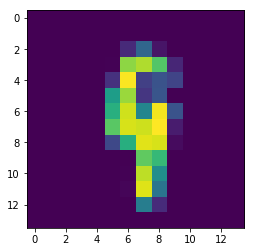

In [31]:
plt.imshow(test_input_1[131].view(14,14))

In [32]:
model(test_input_1[131].view(1,1,14,14)).max(1)[1].item()

9

In [33]:
test_classes.flatten()[131]

tensor(9)

## 1.4 Comparing the n pairs

In [34]:
def compare_pair(test_input):
    #print("test_input = ", test_input.shape)
    a = test_input[0]
    b = test_input[1]
    
    val_a = model(a.view(1,1,14,14)).max(1)[1].item()
    val_b = model(b.view(1,1,14,14)).max(1)[1].item()
    
    if(val_a > val_b):
        return 0
    else:
        return 1
    
def compare_pairb(input_):
    #print(input_[:,0,:,:].view(-1,1,14,14).shape)
    tensor_a = torch.max(model(input_[:,0,:,:].view(-1,1,14,14)), 1)[1]
    print("tensor_a fdksjgnkjgd = ", tensor_a[20:30])
    #print("tensor_a = fdkjfnsf", tensor_a)
    tensor_b = torch.max(model(input_[:,1,:,:].view(-1,1,14,14)),1)[1]
    print("tensor_a fdksjgnkjgd = ", tensor_b[20:30])
    #print(tensor_a[:,])
    return torch.eq(tensor_a, tensor_b)

In [35]:
pred = torch.tensor([compare_pair(x) for x in train_input])
print("pred = ", pred.shape)
print("train_input = ", train_input.shape)
print("pred obtained with compare_pair", pred[20:30])
print("trainddfbsjdgbdjgbdk = ", train_input.shape)
print("pred obtained with compare_pair_b", compare_pairb(train_input)[20:30])
print(compare_pairb(train_input).shape)

pred =  torch.Size([1000])
train_input =  torch.Size([1000, 2, 14, 14])
pred obtained with compare_pair tensor([1, 1, 1, 1, 0, 1, 1, 0, 1, 0])
trainddfbsjdgbdjgbdk =  torch.Size([1000, 2, 14, 14])
tensor_a fdksjgnkjgd =  tensor([1, 0, 4, 0, 4, 6, 8, 2, 0, 9])
tensor_a fdksjgnkjgd =  tensor([6, 1, 4, 0, 0, 7, 9, 1, 8, 2])
pred obtained with compare_pair_b tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)
tensor_a fdksjgnkjgd =  tensor([1, 0, 4, 0, 4, 6, 8, 2, 0, 9])
tensor_a fdksjgnkjgd =  tensor([6, 1, 4, 0, 0, 7, 9, 1, 8, 2])
torch.Size([1000])


In [36]:
pred = torch.tensor([compare_pair(x) for x in test_input])

In [37]:
train_target

tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,

In [38]:
errors = torch.abs(pred-train_target).sum()

In [39]:
errors = torch.abs(pred-test_target).sum()

In [40]:
print('there is {:d} errors over 1000.'.format(errors.item()))

there is 95 errors over 1000.


### sanity check and parameters loading

parameters : eta = 0.01 epoch = 25 batch size = 200 criterion = maxEntropy
             eta = 0.001 epoch = 25 batch size = 200 criterion = maxEntropy

In [41]:
a = test_input[132][0]
b = test_input[132][1]

In [42]:
val_a = model(a.view(1,1,14,14)).max(1)[1].item()
val_b = model(b.view(1,1,14,14)).max(1)[1].item()

In [43]:
val_a

7

In [44]:
val_b

5

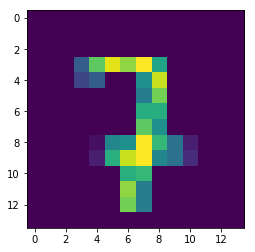

In [45]:
plt.imshow(a)

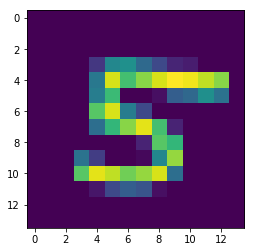

In [46]:
plt.imshow(b)

## 2.0 Architecture 

A second possibility is to treat the input directly as a 2 channel image and predict from the pair directly. This means instead of trying to first guess what the digit is, the network can be trained to only guess if there are different, without trying to "understand" the digits first.

We could also incorporate the class labels in the loss to push the solution towards the correct one. However as noted before, some pairs are wrongly classified and so adding this loss term might actually not help.
When treating the inputs differently (2 images of 1 channel or 1 image with 2 channels), we should try to create very similar networks with the same (or very close) number of parameters to have results that are at least partly comparable.


In [47]:
class Netr(nn.Module):
    def __init__(self,nb_hidden = 200):
        super(Netr, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [48]:
mini_batch_size = 100 
nb_epochs = 25
eta = 0.001 #learning rate
#criterion = nn.L1Loss() # loss
criterion = torch.nn.CrossEntropyLoss()

In [49]:
def train_model(model, train_input, train_target, mini_batch_size, criterion, nb_epochs, eta):
    
    optimizer = torch.optim.SGD(model.parameters(), lr = eta, momentum = 0.95) #Stochastic gradient descent
    
    for e in range(0, nb_epochs):
        # We do this with mini-batches
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            #print("output = ", output[:,0].shape)
            target = train_target.narrow(0, b, mini_batch_size)
            #print("target = ", target.shape)
            #loss = criterion(output,target)
            loss = criterion(output,target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(e, loss.data.item())

In [50]:
model = Net()
print(train_target.shape)
train_model(model, train_input, train_target, mini_batch_size, criterion, nb_epochs, eta)

torch.Size([1000])


RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[100, 2, 14, 14] to have 1 channels, but got 2 channels instead